# Web Scraping from Indeed.com & Predicting Salaries

In this project, I will use two common data science skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

I am going to collect salary information on data science jobs in a variety of markets in the US. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (~93%), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, linear regression could be used for this task; however, I will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, I'll focus on using listings with salary information to build a model and predict additional salaries.

## Scraping job listings from Indeed.com

I will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at an example of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

In [2]:
# Firstly load the libraries needed throughout the scraping and modelling

# Libraries for web scraping
from __future__ import division, unicode_literals
import itertools
import urllib2
import re
import requests
from bs4 import BeautifulSoup

# Libraries for analysis anf plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')

# Libraries for modelling
from scipy import stats
import statsmodels.api as sm
from sklearn import datasets, metrics, linear_model, feature_selection, preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

### Acquiring the data

#### Defining five functions to be used to extract - location, company, job, salary and summary

These five functions will be used to parse the Indeed.com pages to extract the data we need for predicting salaries.

In [250]:
# The location function
# The info on location is in a span with class='location'
def extract_location_from_result(result):
    
    return result.find("span", class_="location").text


# The company function
# The info on company is in a span with class='company'
# Initial attempts at scraping resulted in an errordue to missing company information in the job listings
# Used a try / except statement to combat the error
def extract_company_from_result(result):  
    try: 
        comp = result.find("span", class_="company").text.strip()
    except:
        comp = "None"
    return comp


# The job title function
# The job title is set within an h2 element
def extract_job_title_from_result(result):
    
    return result.h2.a.get("title")


# The salary function
# The salary is set within a nobr element inside of a td element with class='snip'
# Used a try / except statement as not all job listings have salary information (similar to the company function)
def extract_salary_from_result(result):
    try:
        sal = result.find('td', class_='snip').nobr.text
    except:
        sal = ""
    return sal


# The summary function
# The job summaryis set in a span with class = 'summary'
def extract_summary_from_result(result):
    
    return result.find("span", class_="summary").text.strip()

#### Scraping using BeautifulSoup

To get a accumulate a large number of job listing in order to extract enough salary information to make reliable predictions. For this a number [US cities](http://uk.pcmag.com/internet-products/32585/gallery/14-high-tech-cities-youll-want-to-call-home) with large tech sectors were chosen.

In [251]:
# Define the URL for the scraping, location(l) and start are query parameters
url = "https://www.indeed.com/jobs?q=Data+Science+%2420000&l={}&start={}"

# A list of the cities identified
cities = ['Seattle', 'Washington+DC', 'Baltimore', 'Boston','Sacramento', 
          'Los+Angeles', 'Denver', 'San+Diego','Houston', 'Austin', 'Philadelphia', 
          'Kansas+City', 'Portland', 'Minneapolis', 'Atlanta','New+York', 'San+Francisco', 'San+Jose']

# The max number of job listings per city
max_results = 1000

In [75]:
# Assign a blank list to store the results of the scraping
processed = []

# Loop through each city in the cities list
for city in set(cities):
    
    for start in range(0, max_results, 20): # Loop through the the job listings foe each city, 20 at a time
        
        response = requests.get(url.format(city, start)) # Format the URL with the identified query parameters
        page = response.text
        soup = BeautifulSoup(page, "lxml")
        result_list = soup.findAll("div", class_=" row result")
        
        for result in result_list[:]: # loop through the results and apply the functions to extract
        
            location = extract_location_from_result(result)
            job = extract_job_title_from_result(result)
            company = extract_company_from_result(result)
            salary = extract_salary_from_result(result)
            summary = extract_summary_from_result(result)

            processed.append([city, location, job, company, summary, salary]) # Append the list with the extracted data

In [252]:
# Let's look at a the first item in processed
processed[0]

[u'New+York',
 u'New York, NY 10016 (Gramercy area)',
 'Data Science Analyst',
 u'Aetna',
 u'Demonstrates proficiency in several areas of data modeling, machine learning algorithms, statistical analysis, data engineering and data visualization....',
 u'']

The city from the cities list was added to the lists **processed** to help with the salary predictions. It saves time having to clean the scraped location information.

In [256]:
# Create a dataframe from the results in the processed list
df = pd.DataFrame(processed, columns=["City", "Location", "Job", "Company", "Summary", "Salary"])

# Print the number of job listings identified
print len(test), 'job listing have been scraped from Indeed.com'

7662 job listing have been scraped from Indeed.com


### Data cleaning

Only a small proportion of the scraped data will have salary information and it is only this data I will need for modelling. The salary information is represented in several timescales, yearly, monthly, weekly and hourly. Some of the information is also represented as a range.

I will perform the following to extract and clean the salary data:

- Remove duplicate entries
- Delete rows that are missing data
- Only select salary information relating to year, month or week
- Convert salary information to a float (if in a range I will calculate the mean)
    - Round up monthly and weekly salaries to yearly (not the most accurate but is needed to maintain a workable amount of data for the modelling


#### Removing duplicated

In [257]:
# Removing duplicates using drop_duplicates()
df = df.drop_duplicates()

In [260]:
print 'There are', df.shape[0], 'job listings after removing duplicates'

There are 7087 job listings after removing duplicates


#### Deleting rows with missing data

In [261]:
# Deleting rows with missing information
df = df.dropna(how = 'all')

print 'There are', df.shape[0], 'job listings after deleting rows with missing data'

There are 7087 job listings after deleting rows with missing data


There was no missing information in any of the other rows

#### Selecting relevant salary information

In [263]:
# Redefine the dataframe to only include rows with salary information for yesr, month or week
df = df.loc[df.Salary.str.contains("year") | df.Salary.str.contains("month") | 
            df.Salary.str.contains("week")]

print 'There are', df.shape[0], 'job listings with relevant salary information'

There are 330 job listings with relevant salary information


This is quite a reduction in the number of job listing. Only ~4.6% of listings had salary information.

#### Salary conversion

In [264]:
# This function converts the salary info into a float and rounds up the monthly and weekly salaries
def converter(salary):
    
    # Replace the non numerical characters with a blankspace
    salary = salary.replace('$', '') 
    salary = salary.replace(',', '')
    salary = salary.replace('−', ' ')
    
    # Converts yearly salaries to floats and calculates the mean if a range
    if salary.find('year') > -1:
        numerise = [int(s) for s in salary.split() if s.isdigit()]
        return np.mean(numerise)
    
    # Converts monthly salaries to floats, calculates the mean if a range and multiplies by 12
    elif salary.find('month') > -1 :
        get_digits = [int(s) for s in salary.split() if s.isdigit()]
        return (np.mean(get_digits))*12
    
    # Converts weekly salaries to floats, calculates the mean if a range and multiplies by 52
    elif salary.find('week') > -1 :
        get_digits = [int(s) for s in salary.split() if s.isdigit()]
        return (np.mean(get_digits))*52

In [265]:
# Apply function to salary information
df.Salary = df.Salary.apply(converter)

In [314]:
# Reset the index
df.reset_index(inplace = True)

#### Data review

Let's look at the cleaned salary information in more detail.

In [316]:
df.Salary.describe()

count       330.000000
mean      78929.598485
std       35443.313226
min       21000.000000
25%       52715.000000
50%       72698.500000
75%       97404.000000
max      225000.000000
Name: Salary, dtype: float64

We can see that the median is slightly lower than the mean which means that the distribution of the salaries will me positively skewed. We can plot the distribution below.

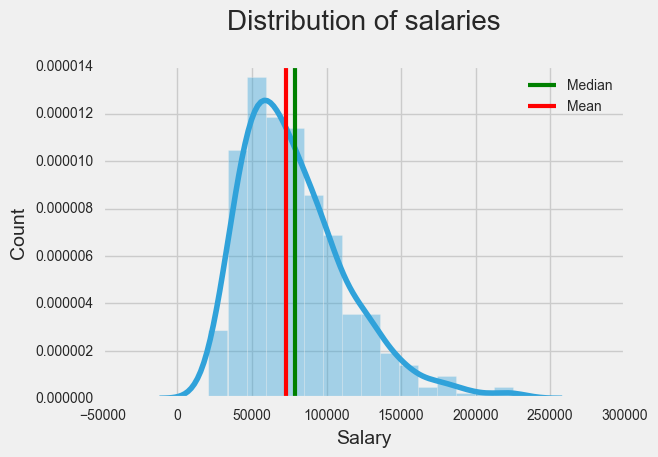

In [317]:
ax = sns.distplot(df.Salary)
ax.set_title('Distribution of salaries\n', size = 20)
ax.set_ylabel('Count', size = 14)
ax.set_xlabel('Salary', size = 14)
ax.axvline(df.Salary.mean(), color = 'green', linewidth = 3)
ax.axvline(df.Salary.median(), color = 'red', linewidth = 3)
ax.legend(['Median', 'Mean'])
plt.show()

Let's look at the average salaries for each of the cities that we identified for our scraping.

/Users/conorhickey/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


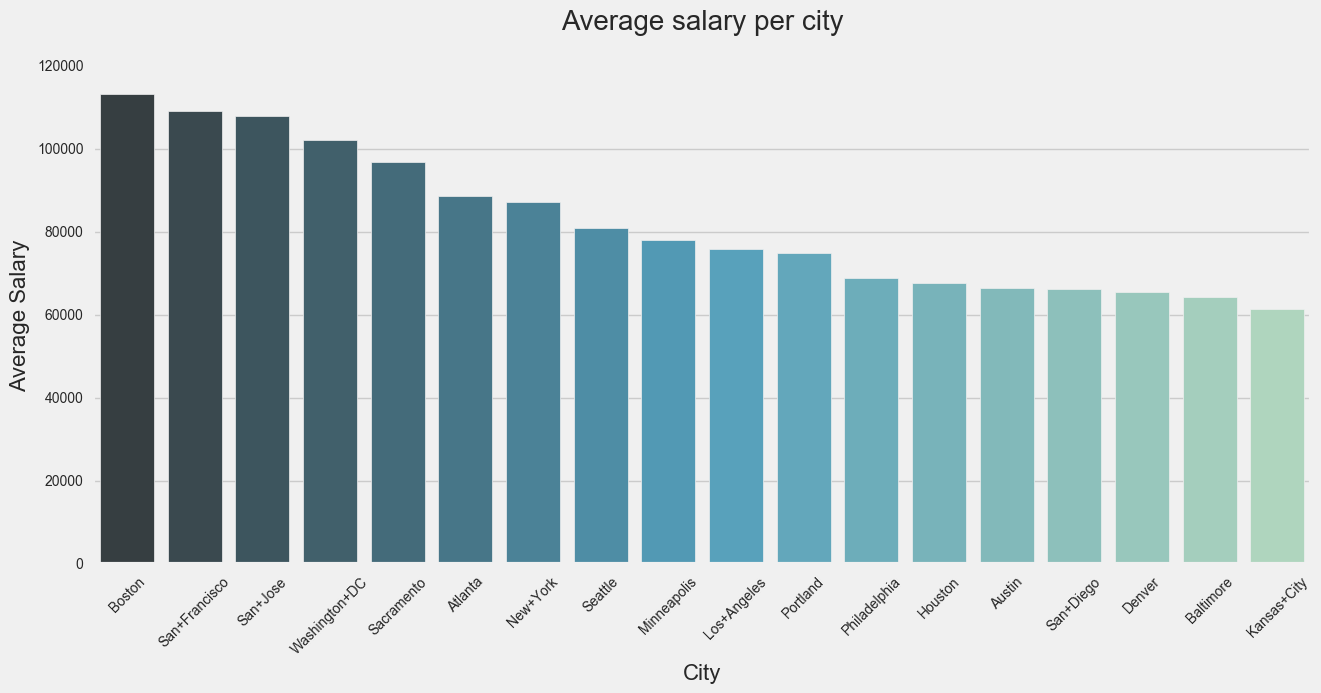

In [318]:
# Grouping salary by city and calculating the mean salary
mean_sal = df.groupby(['City'])['Salary'].mean()

# Sort the salaries in decending order
mean_sal.sort(ascending=False)

# Plot a barchart
fig=plt.figure(figsize=(16,6))
ax = sns.barplot(x = mean_sal.index, y = mean_sal.values, palette = 'GnBu_d')
ax.set_title('Average salary per city\n', size = 20)
ax.set_ylabel('Average Salary', size = 16)
ax.set_xlabel('City', size = 16)
plt.xticks(rotation = 45)
plt.show()

#### Saving dataframe as a CSV

In [319]:
# It is recommended to use UTF-8 encoding as it is dominant on the web and could cause issues
df.to_csv('Resources/Indeed_Salaries.csv', encoding="utf-8")

## Modelling

#### Loading in the csv file of the cleaned scraped salaries

In [3]:
df = pd.read_csv("Resources/Indeed_Salaries.csv")

#### I want to predict a binary variable i.e. whether the salary was low or high. 

For this I will need to calculate the median salary and create a new column that is **1** when the salary is high (above the median) and **0** when the salary is low (below the median)

In [4]:
# The function will calculate a binary output of the salary
def bin_salary(salary):
    
    if salary >= df.Salary.median():
        return 1
    
    else:  
        return 0
    

# Create a new column in the dataframe and apply the binary function
df['Salary_Class'] = df.Salary.apply(bin_salary)

#### Thought experiment: What is the baseline accuracy for this model?

The predicted baseline accuracy for the model will be 50 percent. This is to be expected as the salaries have been split along the median and so half the salaries are below the median and half the salaries are above the median.

In [5]:
print 'Baseline accuracy:', 1 - np.mean(df.Salary_Class)

Baseline accuracy: 0.5


### Logistic Regression using statsmodel

I will use the location as the variable in my first model, the City column will need to be converted into categorical. This will serve as the base for future models.

First I will look at the number salaries per city.

In [6]:
df.City.value_counts()

Austin           34
Denver           34
New+York         32
Seattle          26
Baltimore        26
Houston          25
Portland         20
San+Diego        18
San+Francisco    17
Los+Angeles      16
Washington+DC    15
Philadelphia     15
Boston           11
Minneapolis      11
Sacramento       10
San+Jose          9
Atlanta           8
Kansas+City       3
Name: City, dtype: int64

In [99]:
# Create new variables representing the each of the different cities 
city_cat = pd.get_dummies(df.City, prefix='City')

In [100]:
# Look at the new City variables
city_cat.head()

,City_Atlanta,City_Austin,City_Baltimore,City_Boston,City_Denver,City_Houston,City_Kansas+City,City_Los+Angeles,City_Minneapolis,City_New+York,City_Philadelphia,City_Portland,City_Sacramento,City_San+Diego,City_San+Francisco,City_San+Jose,City_Seattle,City_Washington+DC
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Define target and feature set for modelling
X = city_cat
y = df.Salary_Class

In [10]:
# Define the model 
logit = sm.Logit(y, X)

# Fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.624386
         Iterations 6


In [11]:
# Print the summary statistics for the model
print result.summary()

                           Logit Regression Results                           
Dep. Variable:           Salary_Class   No. Observations:                  330
Model:                          Logit   Df Residuals:                      312
Method:                           MLE   Df Model:                           17
Date:                Mon, 21 Aug 2017   Pseudo R-squ.:                 0.09920
Time:                        11:50:20   Log-Likelihood:                -206.05
converged:                       True   LL-Null:                       -228.74
                                        LLR p-value:                 0.0002136
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
City_Atlanta                0      0.707          0      1.000      -1.386       1.386
City_Austin           -0.6061      0.359     -1.689      0.091      -1.310       0.097
City_Baltimore      

#### Odds Ratio

By taking the exponential of each of the coefficients we can generate the odds ratios. These tells you how a 1 unit increase or decrease in a variable affects the odds of getting a higher or lower salary.

This is a much easier to interept than looking at the coeffecients.

In [12]:
# Calculate the exponential of the coeffecients and sort in decending order
print np.exp(result.params.sort_values(ascending = False))

City_Boston           10.000000
City_Washington+DC     4.000000
City_San+Jose          3.500000
City_San+Francisco     3.250000
City_Sacramento        2.333333
City_Minneapolis       1.750000
City_New+York          1.461538
City_Seattle           1.363636
City_Los+Angeles       1.285714
City_Atlanta           1.000000
City_Portland          0.818182
City_San+Diego         0.800000
City_Philadelphia      0.666667
City_Houston           0.562500
City_Austin            0.545455
City_Kansas+City       0.500000
City_Denver            0.478261
City_Baltimore         0.300000
dtype: float64


From the odds ratios we can see that see the odds of getting a higher salary in Boston are 10 times that of Atlanta and the odds of getting a higher salary in Baltimore 70% lower.

The top cities for getting a higher salary are -  

- Boston
- Washington DC
- San Jose
- San Francisco
- Sacramento

#### Creating new variables for the model



Using the Jobs column I will look for key words in the job titles using Count Vectoriser, extracting them to create new feature variables.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

In [97]:
cv = CountVectorizer(analyzer='word', max_features = 10, stop_words='english', ngram_range=(1,2))
jobs = cv.fit_transform(df['Job']).todense()
job_dummies = pd.DataFrame(jobs, columns = cv.get_feature_names())

In [98]:
job_dummies.sum().sort_values(ascending=False)

analyst        71
data           57
specialist     41
research       37
engineer       26
senior         25
manager        23
assistant      23
scientist      22
coordinator    21
dtype: int64

The top 10 key words from the job titles are - 

- analyst
- data
- specialist
- research
- engineer
- senior
- manager
- assistant
- scientist
- coordinator

I will use these as the new feature variables for my model.

In [33]:
# First I will change all of the job titles to lowercase to make searching through them easier
df.Job = df.Job.apply(lambda x: x.lower())

In [44]:
# Create new columns for each of the new feature variables
# The colums will be 1 when the key word is found in job title and 0 if it isn't
# Some key words can be represented in different spellings, I will search for all
df['Job_Coorddinator'] = df['Job'].str.contains('|'.join(['coordinator', 'co-ordinator'])).astype(float)
df['Job_Senior'] = df['Job'].str.contains('|'.join(['senior', 'sr', 'sr.', 'lead'])).astype(float)
df['Job+Assistant'] = df['Job'].str.contains('assistant').astype(float)
df['Job_Engineer'] = df['Job'].str.contains('engineer').astype(float)
df['Job_Data'] = df['Job'].str.contains('data').astype(float)
df['Job_Scientist'] = df['Job'].str.contains('scientist').astype(float)
df['Job_Analyst'] = df['Job'].str.contains('analyst').astype(float)
df['Job_Specialist'] = df['Job'].str.contains('specialist').astype(float)
df['Job_Manager'] = df['Job'].str.contains('manager').astype(float)
df['Job_Research'] = df['Job'].str.contains('|'.join(['research', 'researcher'])).astype(float)                                        

In [50]:
df.drop('Job_Director', axis=1, inplace=True)

In [51]:
# Define the new target and feature set for modelling
X = pd.concat([city_cat, df.drop(['City', 'Location', 'Job', 'Company', 'Summary', # Join the previous city variables
                                  'Salary', 'Salary_Class'], axis = 1)], axis = 1) # and the new key word variables
y = df.Salary_Class

In [52]:
# Define the model 
logit = sm.Logit(y, X)

# Fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.525581
         Iterations 6


In [53]:
print result.summary()

                           Logit Regression Results                           
Dep. Variable:           Salary_Class   No. Observations:                  330
Model:                          Logit   Df Residuals:                      302
Method:                           MLE   Df Model:                           27
Date:                Mon, 21 Aug 2017   Pseudo R-squ.:                  0.2417
Time:                        13:37:20   Log-Likelihood:                -173.44
converged:                       True   LL-Null:                       -228.74
                                        LLR p-value:                 4.405e-12
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
City_Atlanta          -0.3503      0.830     -0.422      0.673      -1.977       1.277
City_Austin           -0.8300      0.470     -1.764      0.078      -1.752       0.092
City_Baltimore      

#### Odds Ratio

In [54]:
# Calculate the exponential of the coeffecients and sort in decending order
print np.exp(result.params.sort_values(ascending = False))

City_Boston           5.226196
Job_Engineer          3.490156
City_San+Jose         3.428093
Job_Senior            3.195346
City_San+Francisco    2.965571
Job_Manager           2.814530
Job_Data              2.477319
City_Seattle          2.315908
City_Washington+DC    1.960916
City_Sacramento       1.927704
City_Los+Angeles      1.701882
Job_Scientist         1.691242
Job_Analyst           1.549711
City_Minneapolis      1.495627
City_San+Diego        1.050908
City_New+York         0.749167
City_Atlanta          0.704465
City_Portland         0.563710
City_Houston          0.523187
City_Philadelphia     0.470179
City_Denver           0.439444
City_Austin           0.436040
Job_Research          0.337308
City_Kansas+City      0.302906
Job_Specialist        0.285512
Job_Stat              0.234420
Job+Assistant         0.202346
City_Baltimore        0.162396
dtype: float64


As predicted, senior job titles (Engineer, Senior, Manager) have the highest odds of getting a higher salary. 

We also see that the ratios for the City features reduce but the top cities from the first model remain with Boston, San Jose and San Francisco with the highest odds.

### Logistic Regression using sklearn

Using the feature variables obtained from the City and Job columns let's look at Logistic Regression using sklean.

In [55]:
# Redefine the target and feature set for modelling
X = pd.concat([city_cat, df.drop(['City', 'Location', 'Job', 'Company', 'Summary', # Join the previous city variables
                                  'Salary', 'Salary_Class'], axis = 1)], axis = 1) # and the new key word variables
y = df.Salary_Class

In [56]:
# Define the scaler
ss = StandardScaler()

# Scaling the feature set
Xs = ss.fit_transform(X)

Accuracy: 0.754545454545


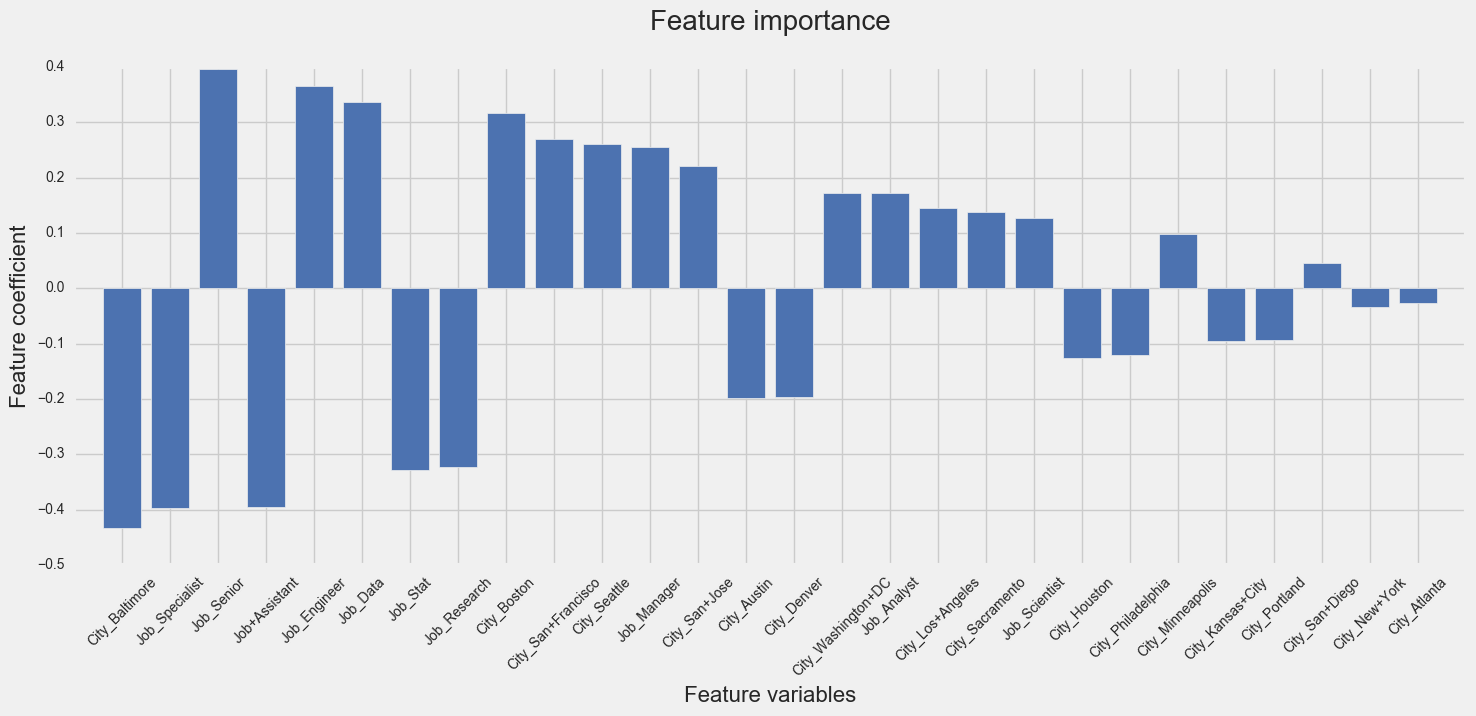

In [57]:
# Defining out model
# Using the standard paramaeters of the model
lr = LogisticRegression()

# Fitting the model with our target and features
model = lr.fit(Xs, y)
# Determins preditions from the model and print the accuracy of the model
predictions = model.predict(Xs)
print 'Accuracy:', accuracy_score(y, predictions)

# Setting the feature importance to a variable
feat_importance = model.coef_
# Sorting the feature importance
indices = np.argsort(np.absolute(feat_importance))

# Plotting the feature importance
plt.figure(figsize = (16, 6))
plt.title("Feature importance\n", fontsize = 20)
plt.bar(range(Xs.shape[1]), feat_importance[0][indices][0][::-1], align="center")
plt.ylabel('Feature coefficient', size = 16)
plt.xlabel('Feature variables', size = 16)
plt.xticks(range(X.shape[1]), X.columns[indices][0][::-1], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

#### Odds ratio

In [58]:
# Create a dataframe to display the odds ratio
odds_ratio = pd.DataFrame(np.transpose(model.coef_), index = X.columns, columns = ["Coeffecient value"])
# Create the odds colums by calculating the exponential of the coefficients
odds_ratio["Odds"] = odds_ratio["Coeffecient value"].apply(np.exp)
# Display the odds ratio
odds_ratio.sort_values(by = 'Odds', ascending = False)

,Coeffecient value,Odds
Job_Senior,0.397082,1.487478
Job_Engineer,0.366153,1.442175
Job_Data,0.336608,1.400190
City_Boston,0.315971,1.371591
City_San+Francisco,0.270324,1.310388
City_Seattle,0.260295,1.297312
Job_Manager,0.256041,1.291806
City_San+Jose,0.220888,1.247184
City_Washington+DC,0.172820,1.188652
Job_Analyst,0.172028,1.187711


From the above chart and table we can see there are similataties with the previous model from statsmodel.

The more senior job titles come out on top as do the previous top cities of Boston, San Francisco, Seattle and San Jose but they are not in the same order of the odds values are also different.


### Cross-validation using sklearn

Using cross-validation I will evaluate different metrics - 

- Accuracy = (TP+TN)/total
- Precision = TP/(TP+FP)
- Recall = TP/(TP+FN)

I will also plot a confusion matrix to understand these metrics better as well as a receiver operating characteristic (ROC) curve to look at the area under the curve (AUC)

In [59]:
# List the metrics for evaluation
metrics = ['accuracy', 'precision', 'recall']

# Define the model 
# Using L2 regularisation and 5-fold cross-validation
lg = LogisticRegressionCV(penalty = 'l2', cv = 5, solver = 'liblinear') 

# Loop through the different metrics and print the mean of the metric after the 5-fold cross-validation
for metric in metrics:
    
    scores = cross_val_score(lg, Xs, y, scoring = metric, cv = 5)
    
    print metric, ':' , scores.mean()

accuracy : 0.533333333333
precision : 0.518737060041
recall : 0.533333333333


#### Confusion matrix

In [60]:
# Define a function for plotting confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix for high/low salaries\n', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True salary')
    plt.xlabel('Predicted salary')
    plt.show()
    return

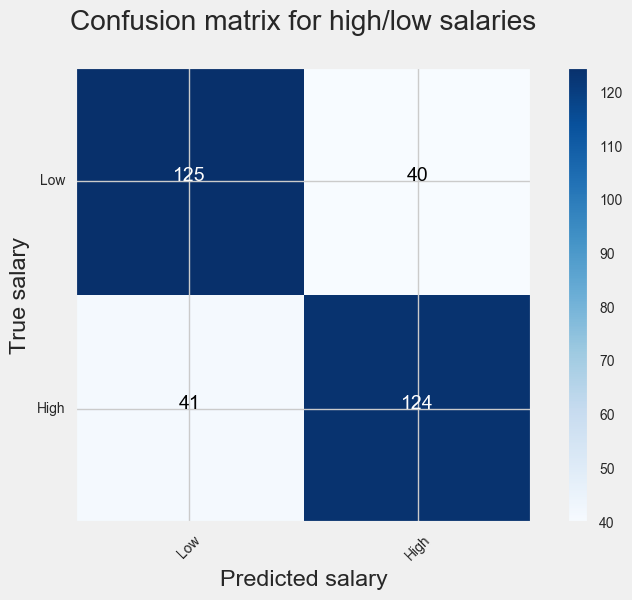

In [61]:
# Plot confusion matrix
cnf_matrix = confusion_matrix(y, model.predict(Xs))
plot_confusion_matrix(cnf_matrix, classes= ['Low', 'High'])

#### ROC curve

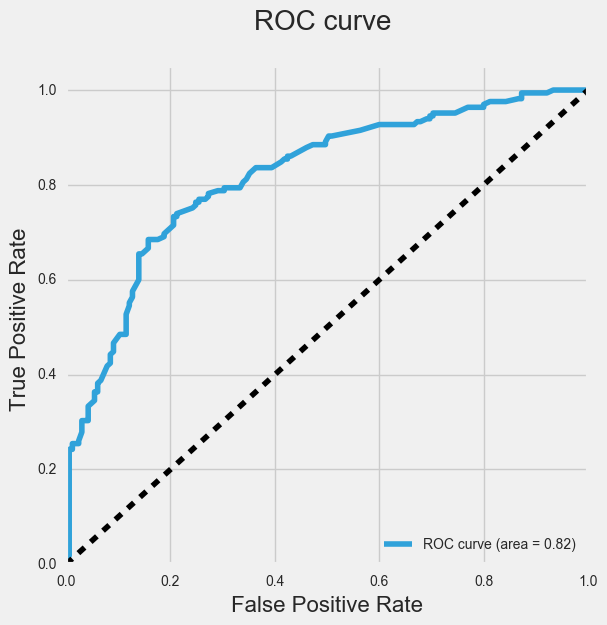

In [62]:
# Plot ROC curve
FPR, TPR, THR = roc_curve(y, model.predict_proba(Xs)[:,1])
ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[6,6])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth = 4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate ', fontsize=16)
plt.title('ROC curve \n', fontsize=20)
plt.legend(loc="lower right")
plt.show()

The accuracy answers the question - _Overall, how often is the classifier correct?_
    - For this model the accuracy score was 0.53 which is lower than the baseline accuracy for the model. This means that model is not better at predicting high salaries than random choice 


The precision answers the question -  _When it predicts yes, how often is it correct?_
    - The score for the precision on this model was ~0.52


The recall answers the question - _When it's actually yes, how often does it predict yes?_
    - The score for the precision on this model was 0.53, similar to the precision


### Comparison of L1 and L2 regularization for this logistic regression model

I will calculate the logistic regression for L1 and L2 penalties and compare the effect this has on the coeffecients.

#### L1 regularisation - Lasso

In [63]:
# Define the model 
# Using L1 regularisation and solver = liblinear as this is better for smaller datasets
lg1 = LogisticRegression(penalty = 'l1', solver = 'liblinear')

# Fit the model with our target and features
lg1.fit(Xs, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty=u'l1', random_state=None, solver=u'liblinear',
          tol=0.0001, verbose=0, warm_start=False)

#### L1 regularisation metrics

In [64]:
# List the metrics for evaluation again
metrics = ['accuracy', 'precision', 'recall']

# Loop through the different metrics and print the mean of the metric after the 5-fold cross-validation
for metric in metrics:
    
    scores = cross_val_score(lg1, Xs, y, scoring = metric, cv = 5)
    
    print metric, ':' , scores.mean()

accuracy : 0.424242424242
precision : 0.394713804714
recall : 0.393939393939


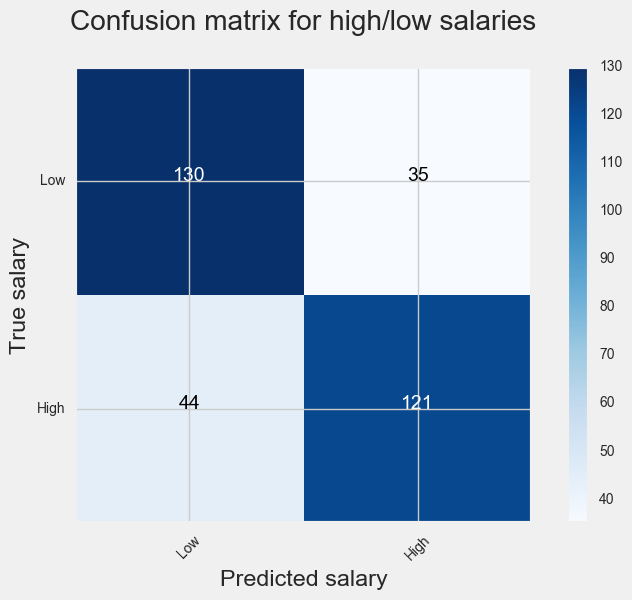

In [65]:
# Plot confusion matrix
cnf_matrix = confusion_matrix(y, lg1.predict(Xs))
plot_confusion_matrix(cnf_matrix, classes= ['Low', 'High'])

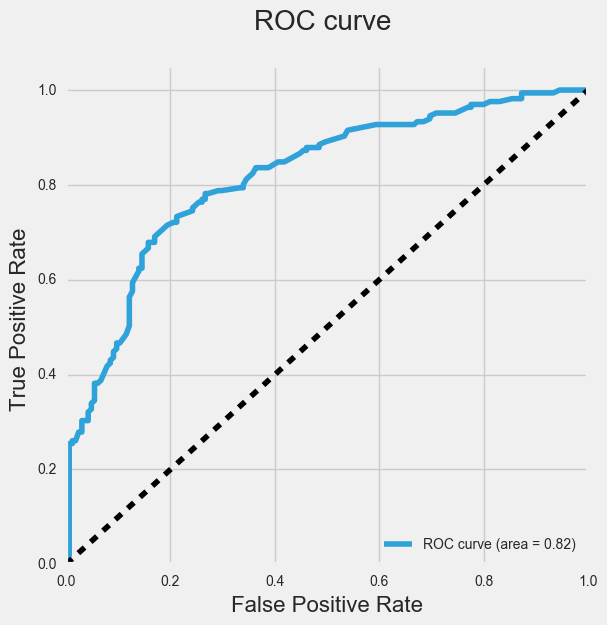

In [66]:
# Plot ROC curve
FPR, TPR, THR = roc_curve(y, lg1.predict_proba(Xs)[:,1])
ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[6,6])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth = 4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate ', fontsize=16)
plt.title('ROC curve \n', fontsize=20)
plt.legend(loc="lower right")
plt.show()

#### Plotting coeffecients for L1

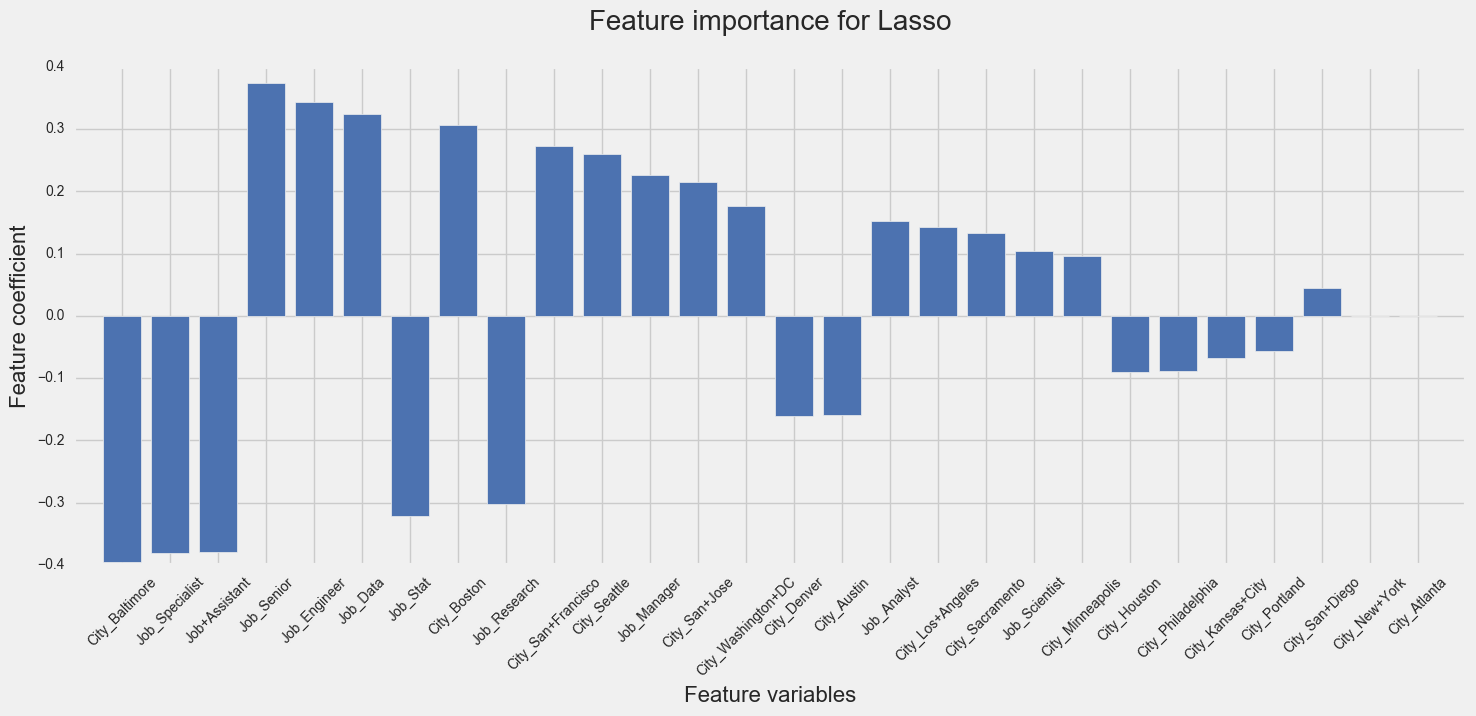

In [67]:
# Setting the feature importance to a variable
feat_importance = lg1.coef_
# Sorting the feature importance
indices = np.argsort(np.absolute(feat_importance))

# Plotting the feature importance
plt.figure(figsize = (16, 6))
plt.title("Feature importance for Lasso\n", fontsize = 20)
plt.bar(range(Xs.shape[1]), feat_importance[0][indices][0][::-1], align="center")
plt.ylabel('Feature coefficient', size = 16)
plt.xlabel('Feature variables', size = 16)
plt.xticks(range(X.shape[1]), X.columns[indices][0][::-1], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

#### L2 regularisation - Ridge

In [68]:
# Define the model 
# Using L2 regularisation and solver = liblinear as this is better for smaller datasets
lg2 = LogisticRegression(penalty = 'l2', solver = 'liblinear')

# Fit the model with our target and features
lg2.fit(Xs, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty=u'l2', random_state=None, solver=u'liblinear',
          tol=0.0001, verbose=0, warm_start=False)

#### L2 regularisation metrics

In [69]:
# List the metrics for evaluation again
metrics = ['accuracy', 'precision', 'recall']

# Loop through the different metrics and print the mean of the metric after the 5-fold cross-validation
for metric in metrics:
    
    scores = cross_val_score(lg2, Xs, y, scoring = metric, cv = 5)
    
    print metric, ':' , scores.mean()

accuracy : 0.433333333333
precision : 0.407183429489
recall : 0.418181818182


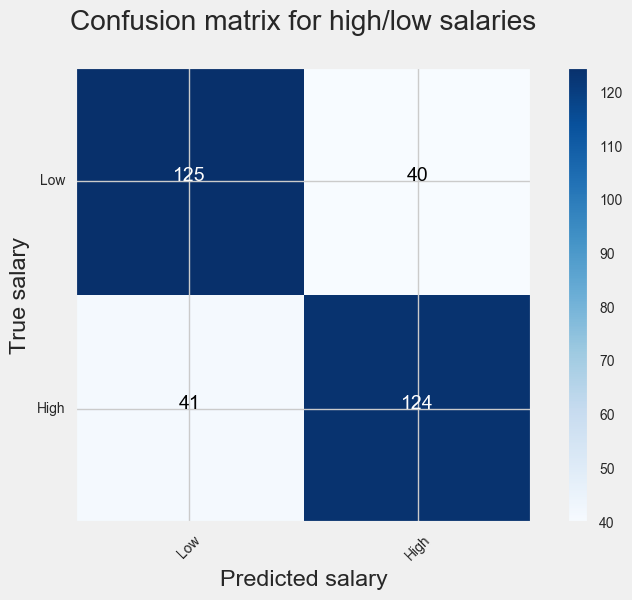

In [71]:
# Plot confusion matrix
cnf_matrix = confusion_matrix(y, lg2.predict(Xs))
plot_confusion_matrix(cnf_matrix, classes= ['Low', 'High'])

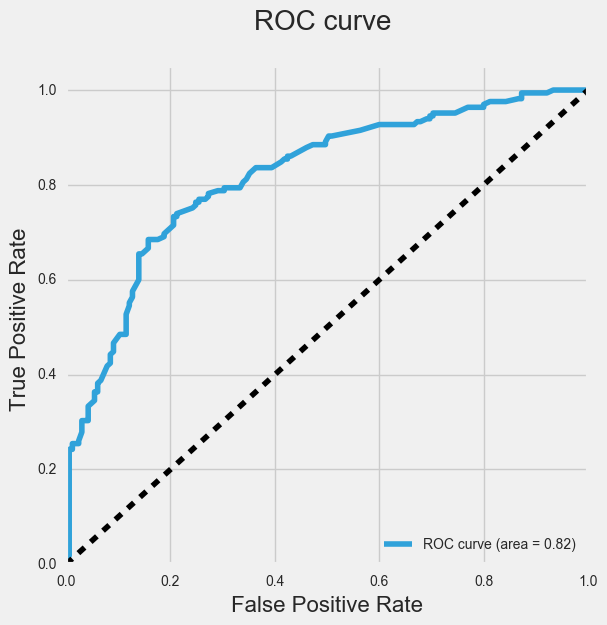

In [72]:
# Plot ROC curve
FPR, TPR, THR = roc_curve(y, lg2.predict_proba(Xs)[:,1])
ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[6,6])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth = 4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate ', fontsize=16)
plt.title('ROC curve \n', fontsize=20)
plt.legend(loc="lower right")
plt.show()

#### Plotting coeffecients for L2

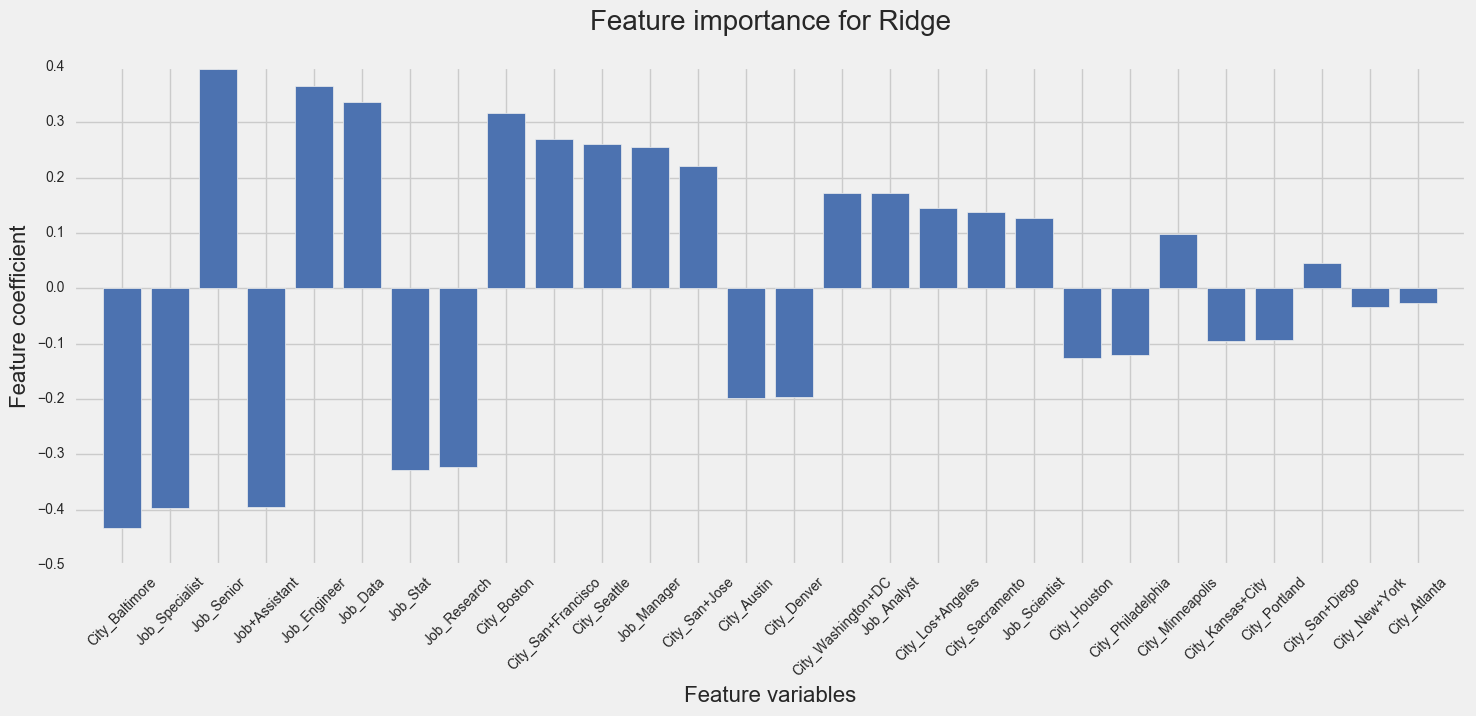

In [73]:
# Setting the feature importance to a variable
feat_importance = lg2.coef_
# Sorting the feature importance
indices = np.argsort(np.absolute(feat_importance))

# Plotting the feature importance
plt.figure(figsize = (16, 6))
plt.title("Feature importance for Ridge\n", fontsize = 20)
plt.bar(range(Xs.shape[1]), feat_importance[0][indices][0][::-1], align="center")
plt.ylabel('Feature coefficient', size = 16)
plt.xlabel('Feature variables', size = 16)
plt.xticks(range(X.shape[1]), X.columns[indices][0][::-1], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

#### Comparing L1 and L2 coeffecients 

In [74]:
# Create a dataframe to display the l1 and l2 coeffecients
comparison = pd.DataFrame(np.transpose(lg1.coef_), index = X.columns, columns = ["Lasso (l1)"])
# Add the l2 coeffecient values to the dataframe
comparison['Ridge (l2)'] = lg2.coef_[0]
# Display the comparison
comparison

,Lasso (l1),Ridge (l2)
City_Atlanta,0.000000,-0.027436
City_Austin,-0.158440,-0.199003
City_Baltimore,-0.394614,-0.433836
City_Boston,0.306812,0.315971
City_Denver,-0.160242,-0.196925
City_Houston,-0.090644,-0.126142
City_Kansas+City,-0.066996,-0.094775
City_Los+Angeles,0.142848,0.144208
City_Minneapolis,0.096593,0.098667
City_New+York,0.000000,-0.032940


Comparing L1 and L2 regularisation, there is definite shrinkage in the coefficient values from the previous two models, statsmodel and sklearn. Senior, engineer and data key words from the job titles come in highest for both l1 and l2.

l1 regularisation has removed several of the City coeffecients (Atlanta and NYC) to make the model more effecient.

Looking at the the accuracy, precision and recall metrics for l1 and l2 we can see that they have all disimproved from the previous models.

To try and improve the model I will perform a GridSearch using different parameters to try and report the best model.

### GridSearch

In [75]:
# Define the GridSearch parameters
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'penalty': ['l1','l2']
         }

# Define the model
grid = GridSearchCV(LogisticRegression(), params, cv=5)
# fit the model
grid.fit(Xs, y)
# Print the beat parameters to use
print grid.best_params_

{u'penalty': u'l2', u'C': 0.001}


The best parameters identified by the GridSearch were - 

- penalty of l2 (Ridge)
- C value of 0.001

I will run another regression with these parameters.

In [76]:
# Define the model 
# Using L2 regularisation, C = 0.001 and solver = liblinear as this is better for smaller datasets
lggs = LogisticRegression(penalty = 'l2', C = 0.001, solver = 'liblinear')

# Fit the model with our target and features
lggs.fit(Xs, y)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty=u'l2', random_state=None, solver=u'liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [77]:
# List the metrics for evaluation again
metrics = ['accuracy', 'precision', 'recall']

# Loop through the different metrics and print the mean of the metric after the 5-fold cross-validation
for metric in metrics:
    
    scores = cross_val_score(lggs, Xs, y, scoring = metric, cv = 5)
    
    print metric, ':' , scores.mean()

accuracy : 0.530303030303
precision : 0.515288784179
recall : 0.527272727273


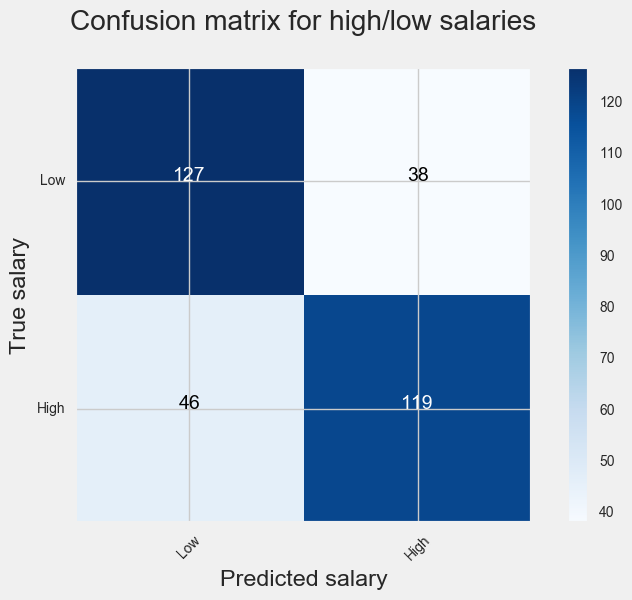

In [78]:
# Plot confusion matrix
cnf_matrix = confusion_matrix(y, lggs.predict(Xs))
plot_confusion_matrix(cnf_matrix, classes= ['Low', 'High'])

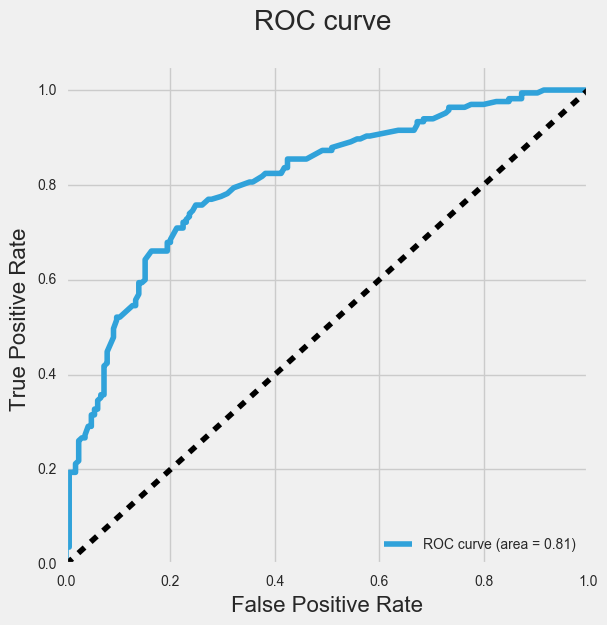

In [79]:
# Plot ROC curve
FPR, TPR, THR = roc_curve(y, lggs.predict_proba(Xs)[:,1])
ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[6,6])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth = 4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate ', fontsize=16)
plt.title('ROC curve \n', fontsize=20)
plt.legend(loc="lower right")
plt.show()

There was a noticable increase in the metric scores after using the optimised parameters identified from the GridSearch.


accuracy : 0.427272727273 -------> 0.545454545455

precision : 0.400586820587 -------> 0.553743168411

recall : 0.424242424242 -------> 0.533333333333


These would improve the model for solving the problem.

#### Split the entries into a training and test set taking ~100 scraped entries in the test set

In [80]:
# Using existing salary data I split it into training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size = 0.3)

# Check the size of the test set
X_test.shape

(99, 28)

In [81]:
# Define the model using the optimised parameters
logit=LogisticRegression(penalty = 'l1', C = 0.1, solver = 'liblinear')
# Fit te model
model=logit.fit(X_train,y_train)

# Calculate predicted values for the training and test sets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Calculate the metric scores for the training set
for metric in metrics:
    scores = cross_val_score(model, X_train, y_train, scoring = metric, cv = 5)
    print 'Train', ':',  metric, scores.mean()

print

# Calculate the metric scores for the test set
for metric in metrics:
    scores = cross_val_score(model, X_test, y_test, scoring = metric, cv = 5)
    print 'Test', ':', metric, scores.mean()

Train : accuracy 0.589295919416
Train : precision 0.546101623445
Train : recall 0.739826839827

Test : accuracy 0.574335839599
Test : precision 0.780357142857
Test : recall 0.427272727273


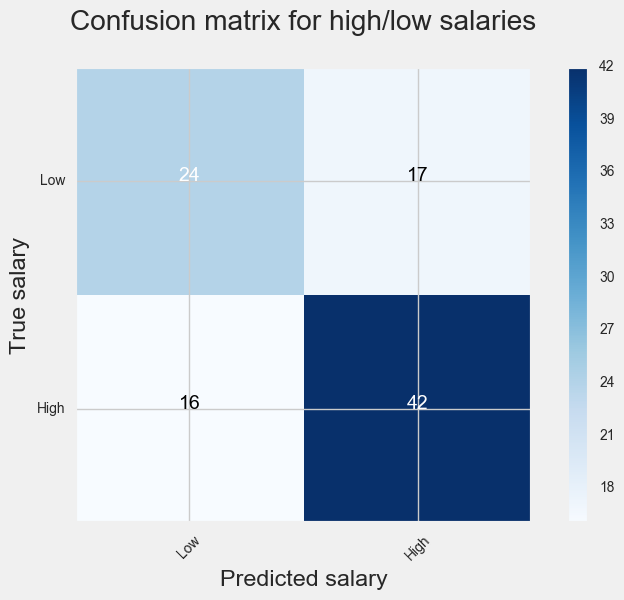

In [82]:
# Plot confusion matrix for the test set
cnf_matrix = confusion_matrix(y_test, model.predict(X_test))
plot_confusion_matrix(cnf_matrix, classes= ['Low', 'High'])

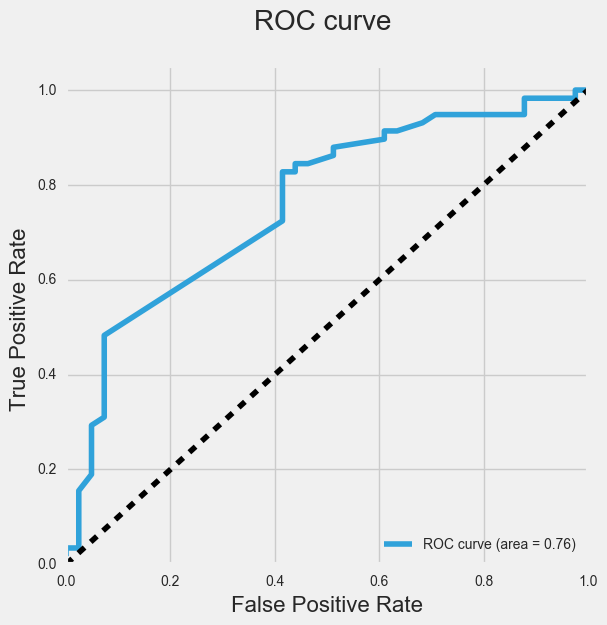

In [110]:
# Plot ROC curve
FPR, TPR, THR = roc_curve(y_test, model.predict_proba(X_test)[:,1])
ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[6,6])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth = 4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate ', fontsize=16)
plt.title('ROC curve \n', fontsize=20)
plt.legend(loc="lower right")
plt.show()

The test set performs worse than the training set in terms of accuracy but the recall is suffeciently lower than the precision score for solving out problem it would be a good model to use.

### BONUS 

### Using Count Vectorizer to create features from the text summaries. 

In [87]:
# Using Countvectorize on the Summary, taking out common words with a maximum word length 2 
# and max number of features as 5
cv = CountVectorizer(stop_words = 'english', max_features = 10, ngram_range = (1, 3), binary=True)
top_words = cv.fit_transform(df.Summary).todense()

In [102]:
# Create a dataframe from the top
top_words = pd.DataFrame(top_words, columns=cv.get_feature_names())
print 'The top 10 words are:\n', top_words.columns.unique()

The top 10 words are:
[u'analyst' u'assistant' u'coordinator' u'data' u'engineer' u'manager'
 u'research' u'scientist' u'senior' u'specialist']


In [103]:
# Redefine the target and predictor variables
X = pd.concat([top_words, city_cat, df.drop(['City', 'Location', 'Job', 'Company', 'Summary', # Join the previous city variables
                                  'Salary', 'Salary_Class'], axis = 1)], axis = 1) # and the new key word variables
y = df.Salary_Class

In [106]:
ss = StandardScaler()
Xs = ss.fit_transform(X)
lr = LogisticRegressionCV(penalty = 'l2', cv = 5, Cs = 20)

# Fit the model with our target and features
lr.fit(Xs, y)

for metric in metrics:
    scores = cross_val_score(lr, Xs, y, scoring = metric, cv = 5)
    print metric, scores.mean()

accuracy 0.539393939394
precision 0.533099493295
recall 0.551515151515


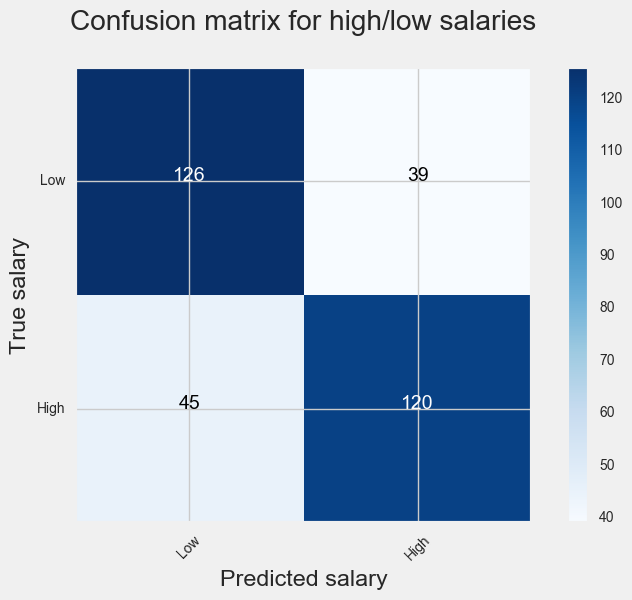

In [107]:
# Plot confusion matrix

cnf_matrix = confusion_matrix(y, lr.predict(Xs))
plot_confusion_matrix(cnf_matrix, classes= ['Low', 'High'])

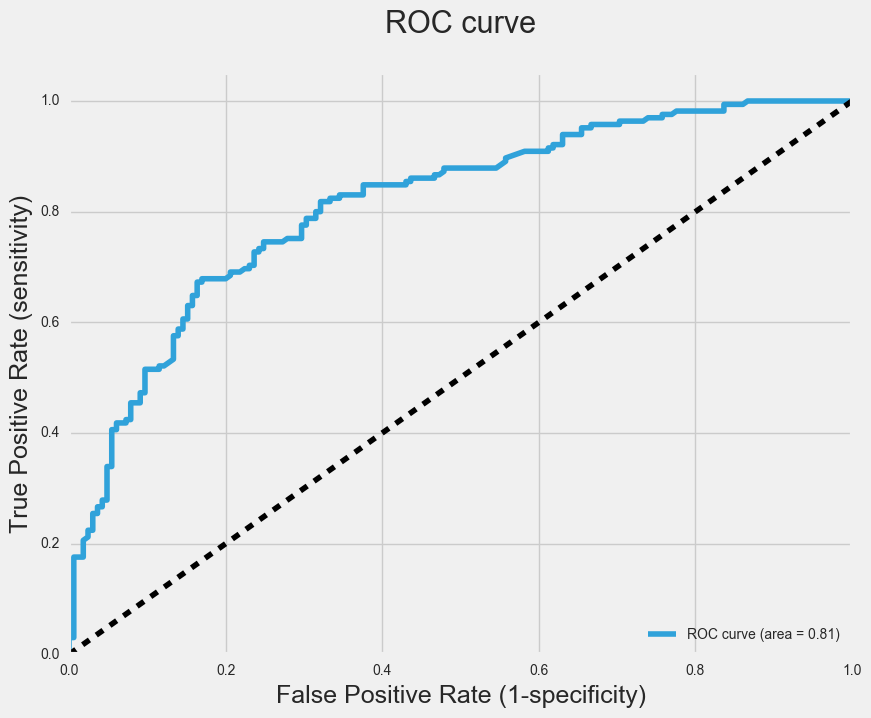

In [108]:
# Plot ROC curve

FPR, TPR, THR = roc_curve(y, lr.predict_proba(Xs)[:,1])
ROC_AUC = auc(FPR, TPR)


plt.figure(figsize=[9,7])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth = 4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-specificity)', fontsize=18)
plt.ylabel('True Positive Rate (sensitivity)', fontsize=18)
plt.title('ROC curve\n', fontsize=22)
plt.legend(loc="lower right")
plt.show()

#### Plotting the coeffecients

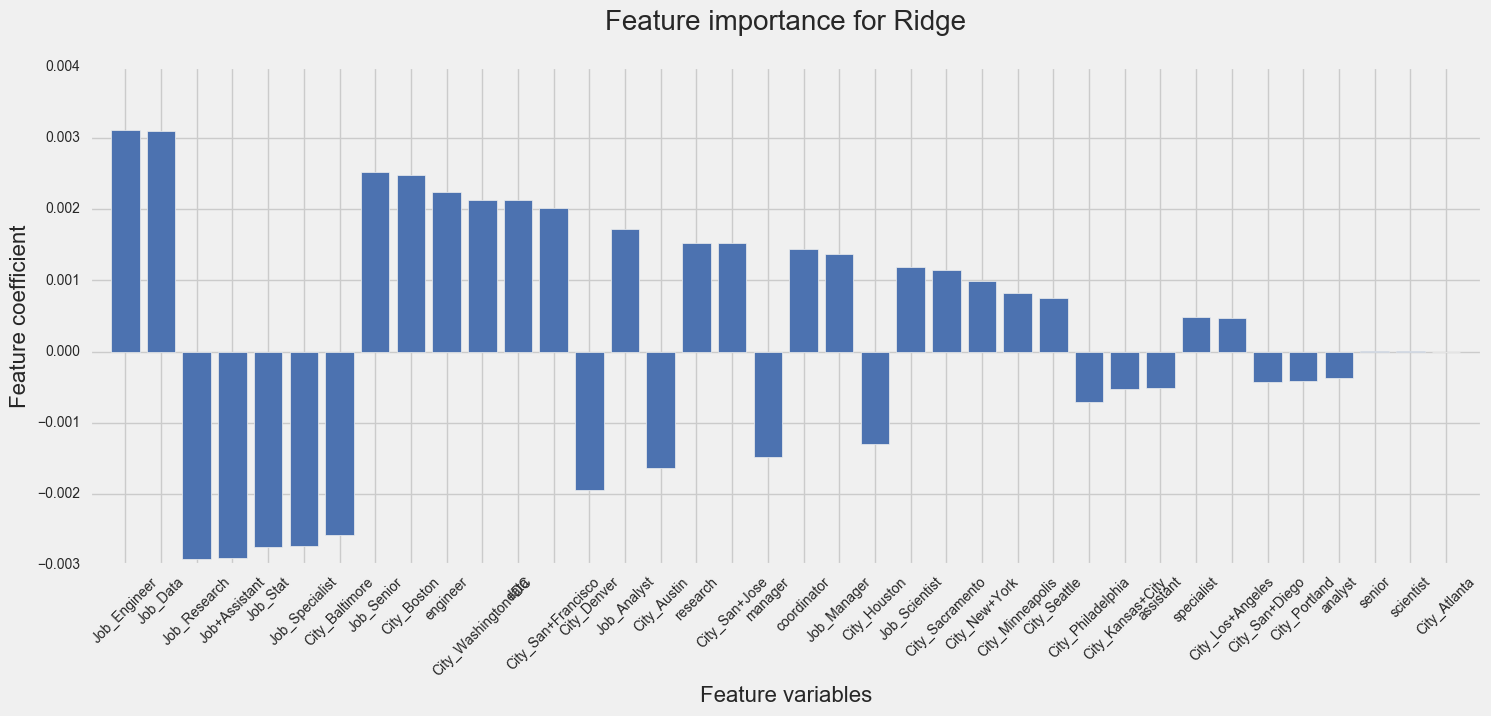

In [109]:
# Setting the feature importance to a variable
feat_importance = lr.coef_
# Sorting the feature importance
indices = np.argsort(np.absolute(feat_importance))

# Plotting the feature importance
plt.figure(figsize = (16, 6))
plt.title("Feature importance for Ridge\n", fontsize = 20)
plt.bar(range(Xs.shape[1]), feat_importance[0][indices][0][::-1], align="center")
plt.ylabel('Feature coefficient', size = 16)
plt.xlabel('Feature variables', size = 16)
plt.xticks(range(X.shape[1]), X.columns[indices][0][::-1], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

From the plot above it is seen that several of the new words from the job summaries have high coeffecients and so are associated tigh higher salaries, these are - 

- data
- computer science
- computer

#### Re-testing  L1 and L2 regularization 

Will use LogisticRegressionCV to find the optimal reguarlization parameters -

- Re-test what text features are most valuable.  
- How do L1 and L2 change the coefficients?

In [111]:
# Define the GridSearch parameters to include the new top words
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'penalty': ['l1','l2']
         }

# Define the model
grid = GridSearchCV(LogisticRegression(), params, cv=5)
# fit the model
grid.fit(Xs, y)
# Print the beat parameters to use
print grid.best_params_

{u'penalty': u'l2', u'C': 0.001}


#### l1 regularisation using the optimised parameters

In [116]:
# Define the model
lr1 = LogisticRegression(penalty = 'l1', C = 0.1, solver = 'liblinear')

# Fit the model with our target and features
lr1.fit(Xs, y)

for metric in metrics:
    scores = cross_val_score(lr1, Xs, y, scoring = metric, cv = 5)
    print metric, scores.mean()

accuracy 0.524242424242
precision 0.514486486486
recall 0.630303030303


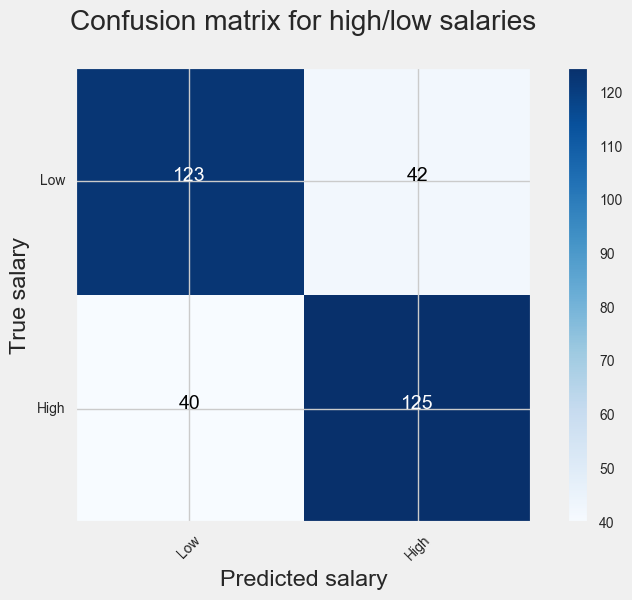

In [117]:
# Plot confusion matrix

cnf_matrix = confusion_matrix(y, lr1.predict(Xs))
plot_confusion_matrix(cnf_matrix, classes= ['Low', 'High'])

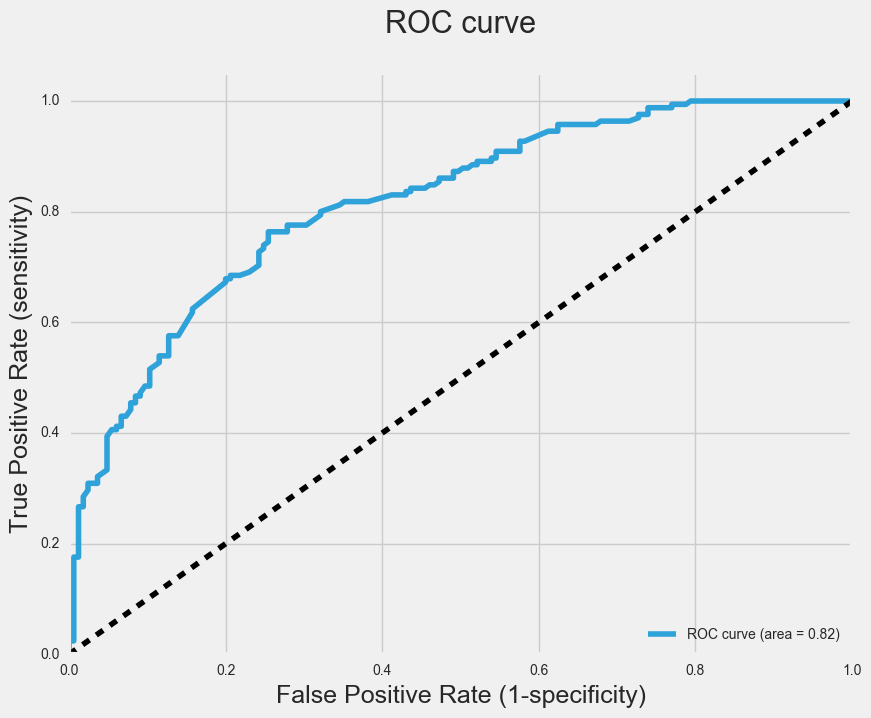

In [118]:
# Plot ROC curve

FPR, TPR, THR = roc_curve(y, lr1.predict_proba(Xs)[:,1])
ROC_AUC = auc(FPR, TPR)


plt.figure(figsize=[9,7])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth = 4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-specificity)', fontsize=18)
plt.ylabel('True Positive Rate (sensitivity)', fontsize=18)
plt.title('ROC curve\n', fontsize=22)
plt.legend(loc="lower right")
plt.show()

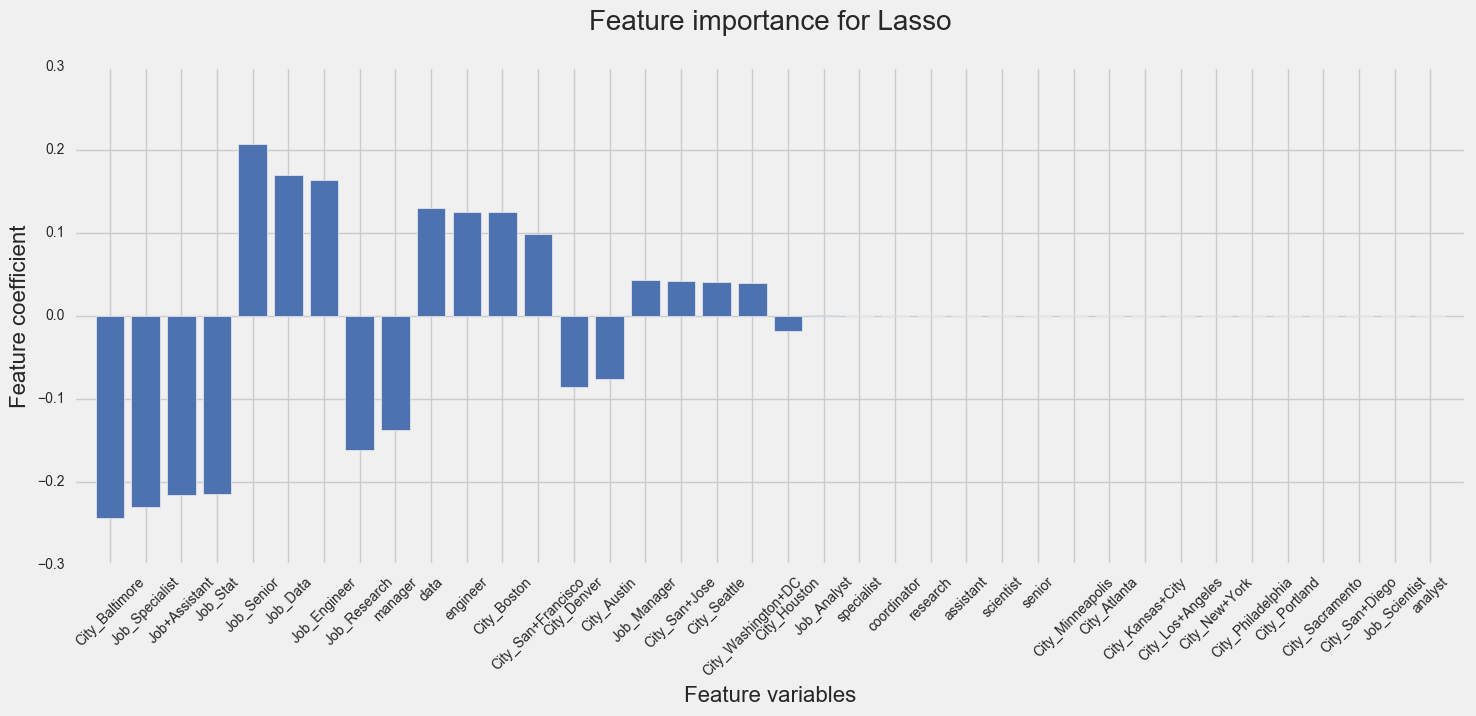

In [119]:
# Setting the feature importance to a variable
feat_importance = lr1.coef_
# Sorting the feature importance
indices = np.argsort(np.absolute(feat_importance))

# Plotting the feature importance
plt.figure(figsize = (16, 6))
plt.title("Feature importance for Lasso\n", fontsize = 20)
plt.bar(range(Xs.shape[1]), feat_importance[0][indices][0][::-1], align="center")
plt.ylabel('Feature coefficient', size = 16)
plt.xlabel('Feature variables', size = 16)
plt.xticks(range(X.shape[1]), X.columns[indices][0][::-1], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

#### l2 regularisation

In [120]:
# Define the model 
# Using L2 regularisation and solver = liblinear as this is better for smaller datasets
lr2 = LogisticRegression(penalty = 'l2', solver = 'liblinear')

# Fit the model with our target and features
lr2.fit(Xs, y)

for metric in metrics:
    scores = cross_val_score(lr2, Xs, y, scoring = metric, cv = 5)
    print metric, scores.mean()

accuracy 0.451515151515
precision 0.430665621873
recall 0.436363636364


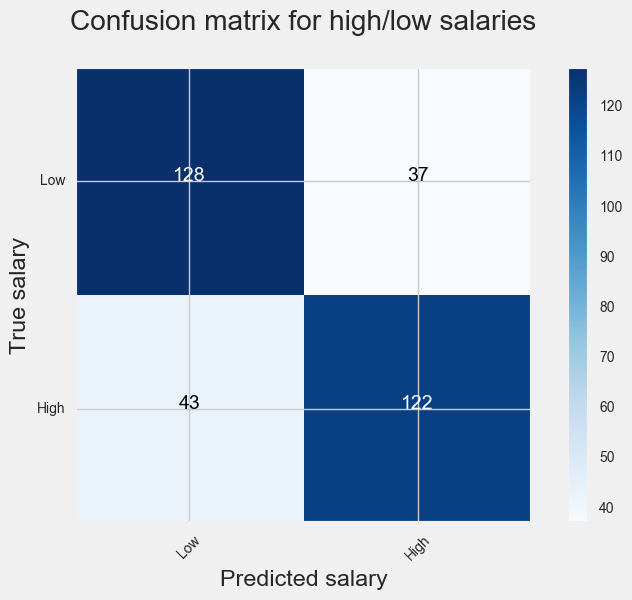

In [121]:
# Plot confusion matrix

cnf_matrix = confusion_matrix(y, lr2.predict(Xs))
plot_confusion_matrix(cnf_matrix, classes= ['Low', 'High'])

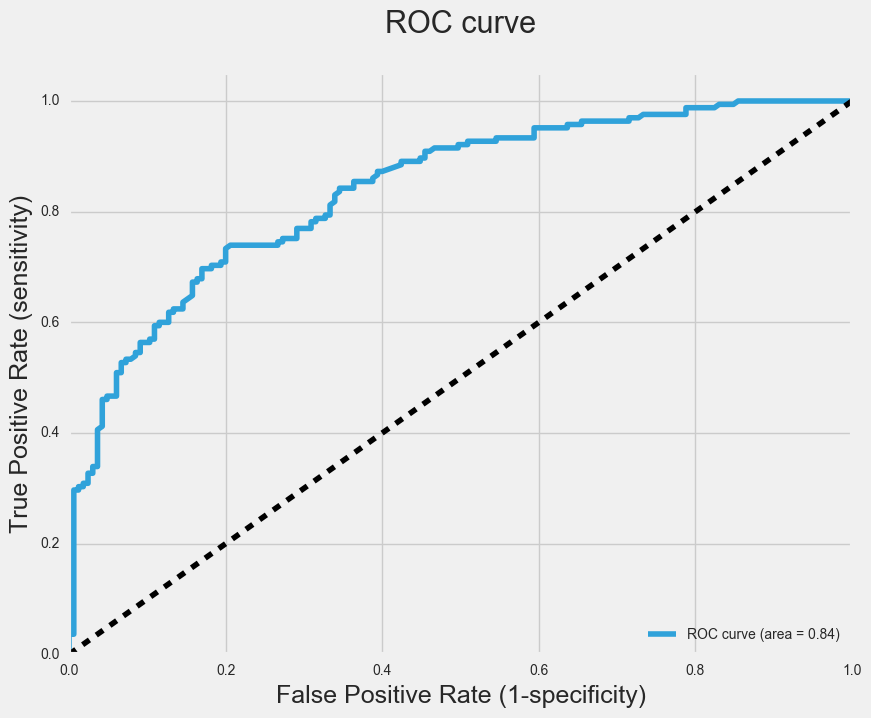

In [122]:
# Plot ROC curve

FPR, TPR, THR = roc_curve(y, lr2.predict_proba(Xs)[:,1])
ROC_AUC = auc(FPR, TPR)


plt.figure(figsize=[9,7])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth = 4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-specificity)', fontsize=18)
plt.ylabel('True Positive Rate (sensitivity)', fontsize=18)
plt.title('ROC curve\n', fontsize=22)
plt.legend(loc="lower right")
plt.show()

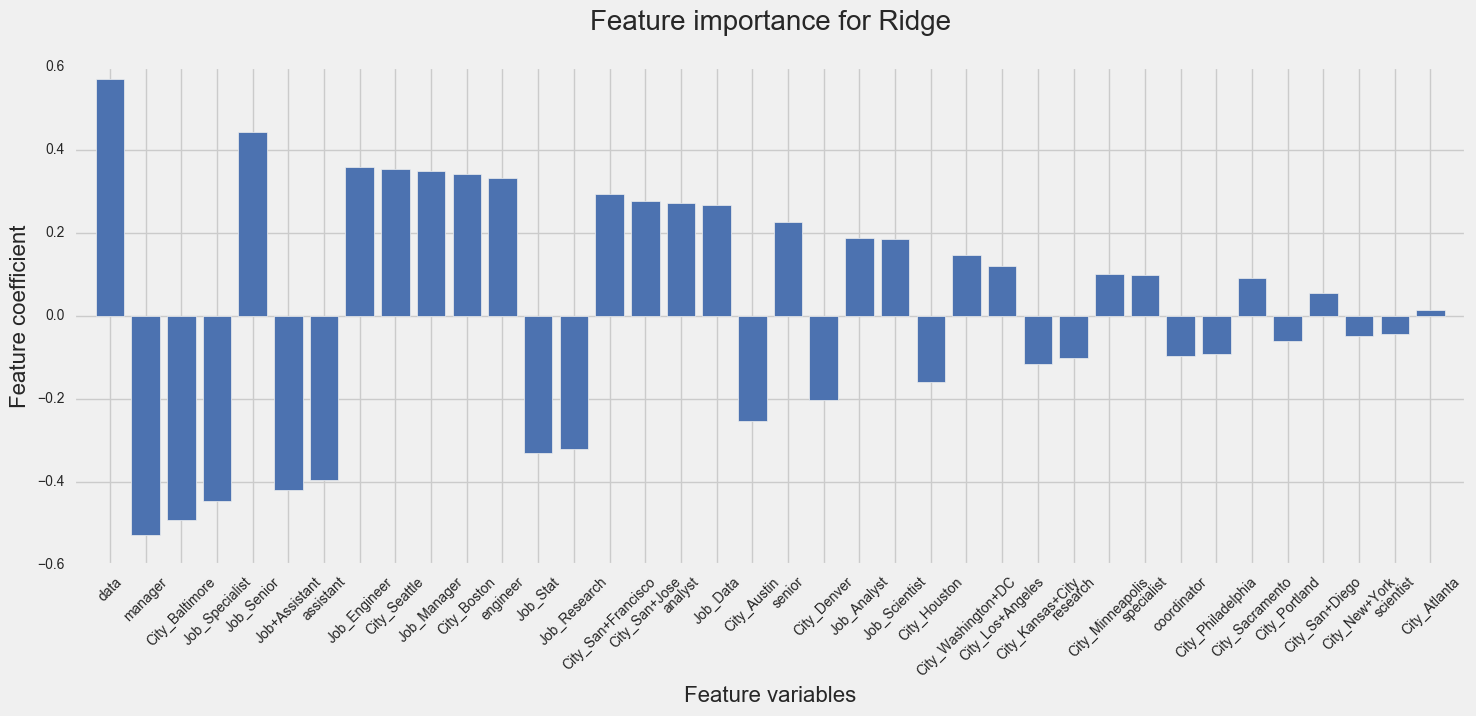

In [123]:
# Setting the feature importance to a variable
feat_importance = lr2.coef_
# Sorting the feature importance
indices = np.argsort(np.absolute(feat_importance))

# Plotting the feature importance
plt.figure(figsize = (16, 6))
plt.title("Feature importance for Ridge\n", fontsize = 20)
plt.bar(range(Xs.shape[1]), feat_importance[0][indices][0][::-1], align="center")
plt.ylabel('Feature coefficient', size = 16)
plt.xlabel('Feature variables', size = 16)
plt.xticks(range(X.shape[1]), X.columns[indices][0][::-1], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

Looking at the two regularisation models above it is clear that l1 or Lasso has simplified the model by removing or reducing the coeffecients for a large proportion of the feature variables.

As with the majority of the models, certain features and key words are good indicators of achieving a higher salary. These are - 

- data (job summary keyword)
- Job_Senior
- Job_Engineer
- City_Seattle
- Job_Manager
- City_Boston
- engineer (job summary keyword)

## Summary

### Introduction
The aim of the project was to collect salary data from Indeed.com and look for relationships between features in job listings and the salaries for those jobs. The task was aimed at predicting Data Science salaries, so the search was focused in this field. The search was also targeted at the United States in known tech hubs.

The result of the investigation identified features in the job listing that were associated with highed salaries, these features related to job titles, location and summary keywords. These includes the cities of Seattle, and Boston as well as job titles containing Senior and Engineer.

### Method
Using Beautiful Soup, 7662 job listings were scraped from 18 cities on Indeed.com. Five functions were used to extract - location, company, job, salary and job summary. These were cleaned and listings without salaries were deleted as most listings DID NOT come with salary information (~93%), this left 330 job listings remaining to perform modelling on.

Although linear regression could have been used the task was converted into classification and Logistic Regression used instead. The salary information was converted into a binary high/low feature with all salaries above the median equalling 1.

Modelling of the different features (job titles, location and summary keywords) was performed to identify the most relevant features for predicting salary.

### Results
Several different models were run on the scraped features from Indeed.com to predict the key features that impact recieving a high salary the most.

It was identified that the following features contributed the most - 

**Job summary keyword**
- data
- engineer

**Job title**
- Senior
- Engineer
- Manager

**City**
- Seattle
- Boston